In [4]:
#!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [5]:
#@title Load coordinates nearest points
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import chi2_contingency

pd.options.display.max_rows = 999


coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/distan_lat41.296lon2.078p2R12Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

Visibility statistics


count    87997.000000
mean      9794.984522
std        914.742469
min        145.000000
25%       9994.000000
50%       9994.000000
75%       9994.000000
max       9994.000000
Name: visibility_o, dtype: float64

*****************************
Climatology visibility <= 1000 meters


>1000m     99.953%
<=1000m     0.047%
Name: vis_l, dtype: object

*****************************


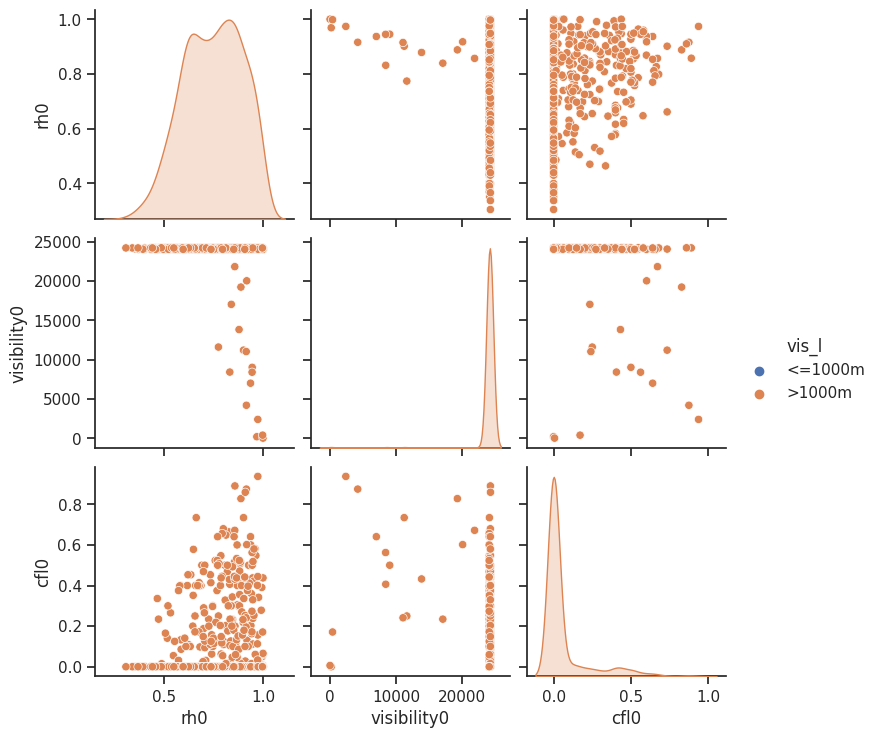

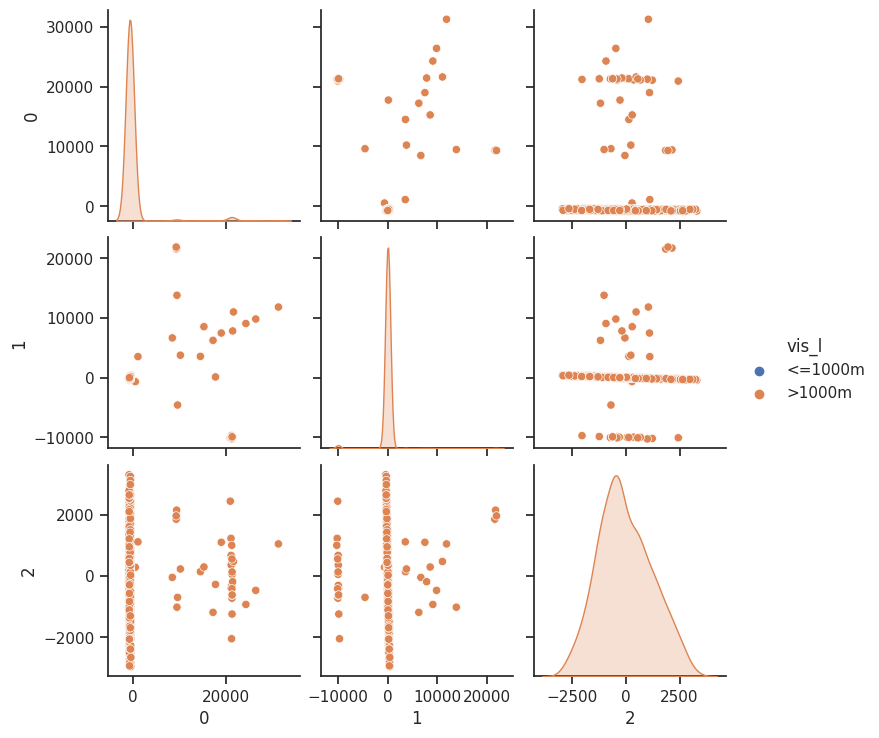

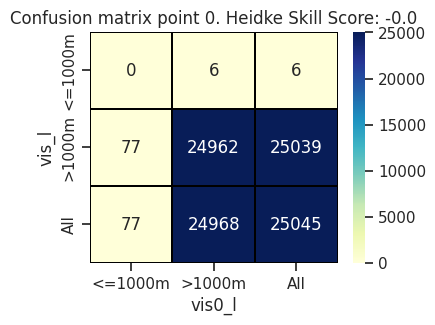

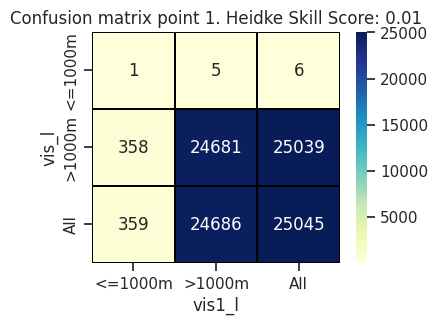

Chi2 contingency test

p-value: 1.0
Significance level: 0.01
Degres of of freedom:  1
Statistic 0.0
Retain H0,There is no association between machine learning forecast and observed values


In [8]:
#@title Load station (visibility). Load meteorological model forecast D0. Display relation visibility with model variables. Heidke skill score (HSS) meteorological model
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/LEBLY2018Y2022.csv",
                          usecols =["time","visibility_o"],
                          parse_dates=["time"]).dropna().set_index("time")

print("Visibility statistics")
display(station["visibility_o"].describe())

#visibility to interval
interval = pd.IntervalIndex.from_tuples([(-0.1,1000), (1000, 40000)])
labels = ['<=1000m', '>1000m']
station["vis_l"] = pd.cut(station["visibility_o"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

print("*****************************")
print("Climatology visibility <= 1000 meters")
display(station["vis_l"].value_counts(normalize=True).map(lambda n: '{:.3%}'.format(n)))

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/lat41.296lon2.078p2R12KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/lat41.296lon2.078p2R12KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/lat41.296lon2.078p2R12KmD0Y2020.csv",parse_dates=["time"])

model = pd.concat([mody2018,mody2019,mody2020]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["visibility_o",]).dropna()
#display(df_all)

#display relation br fg with meteorological model variables
print("*****************************")

sns.set_theme(style="ticks")
df = df_all[["vis_l","rh0","visibility0","cfl0"]].sample(1000)
#plt.figure(figsize=(12, 10))
#plt.title("Display relation br fg with meteorological model variables sample=100")
g1 = sns.pairplot(df, hue="vis_l");
plt.show()

#display relation br fg with meteorological PCA
df_pca = pd.DataFrame(PCA(n_components=3).fit_transform(df_all.iloc[:,1:]),
                                                       index =df_all.index)
df_pca["vis_l"] = df_all.vis_l
#plt.figure(figsize=(12, 10))
#plt.title("PCA analysis sample=100")
g2 = sns.pairplot(df_pca.sample(1000), hue="vis_l");
plt.show()

#label meteorological model variables dir0 and dir1
df_all["vis0_l"] = pd.cut(df_all["visibility0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")
df_all["vis1_l"] = pd.cut(df_all["visibility1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_all.vis_l, df_all.vis0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
cm1 = pd.crosstab(df_all.vis_l, df_all.vis1_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()
plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(cm0.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test association between two variables
alpha = 0.01
print("Chi2 contingency test")
print('\np-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Statistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")


Round 0


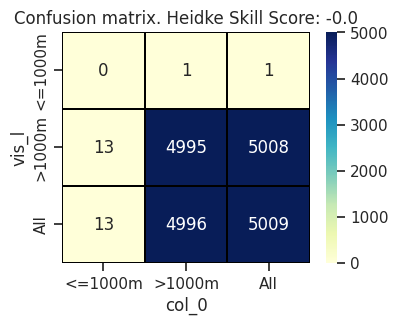

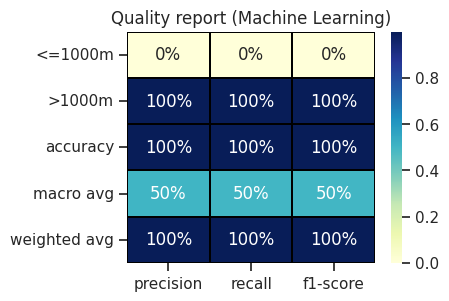

,feature,feature_per
34,lhflx1,5.4%
32,rh1,5.2%
41,cin1,5.2%
0,dir0,4.8%
2,snowlevel0,4.7%
3,mod0,4.2%
16,cin0,3.6%
7,rh0,3.5%
6,temp0,3.4%
8,visibility0,3.3%


Round 1


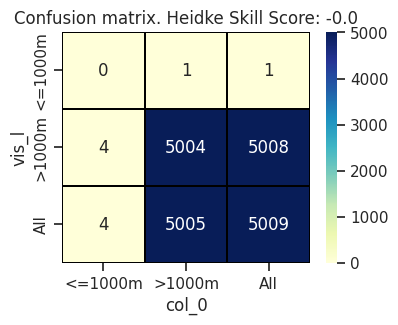

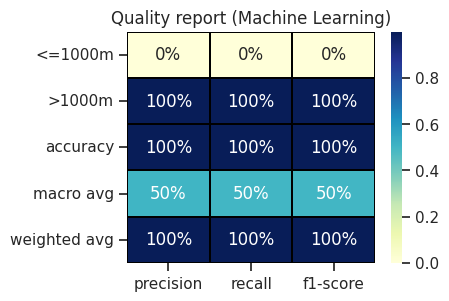

,feature,feature_per
0,dir0,11.2%
2,snowlevel0,7.0%
7,rh0,6.5%
3,mod0,5.4%
34,lhflx1,4.4%
9,lhflx0,3.9%
32,rh1,3.5%
28,mod1,3.2%
5,mslp0,3.0%
4,wind_gust0,2.8%


Round 2


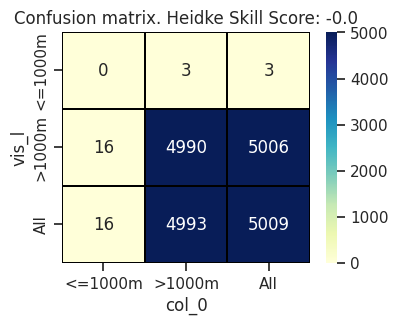

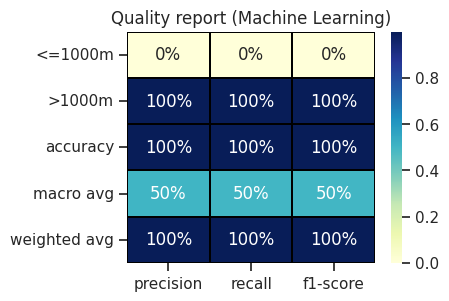

,feature,feature_per
0,dir0,9.5%
41,cin1,5.4%
2,snowlevel0,5.3%
3,mod0,4.6%
5,mslp0,4.5%
32,rh1,4.5%
16,cin0,3.8%
34,lhflx1,3.4%
7,rh0,3.1%
4,wind_gust0,3.1%


Round 3


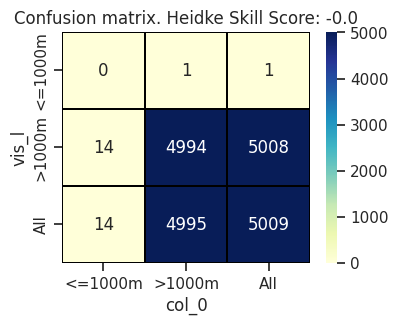

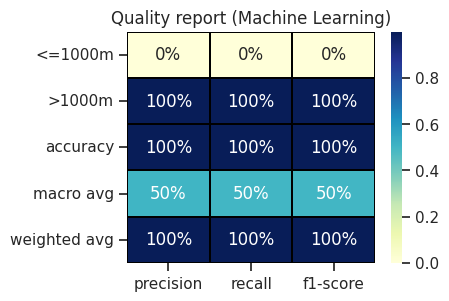

,feature,feature_per
0,dir0,8.2%
34,lhflx1,5.3%
7,rh0,4.6%
8,visibility0,4.6%
9,lhflx0,4.5%
3,mod0,4.3%
16,cin0,4.0%
2,snowlevel0,3.8%
41,cin1,3.4%
10,lwflx0,3.4%


Round 4


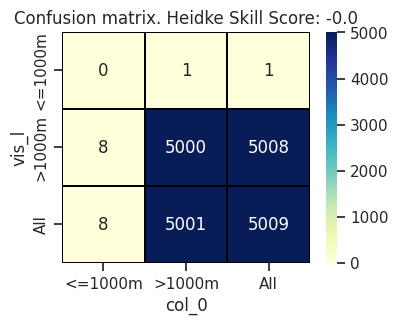

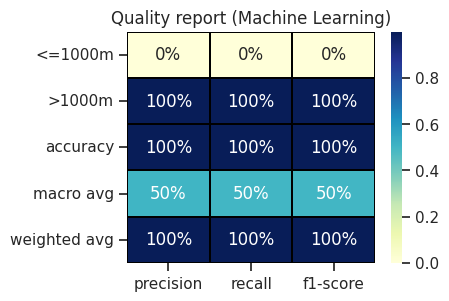

,feature,feature_per
0,dir0,12.0%
2,snowlevel0,6.1%
8,visibility0,4.8%
3,mod0,4.7%
41,cin1,4.5%
7,rh0,3.5%
10,lwflx0,3.3%
5,mslp0,3.3%
4,wind_gust0,3.2%
9,lhflx0,3.1%


Round 5


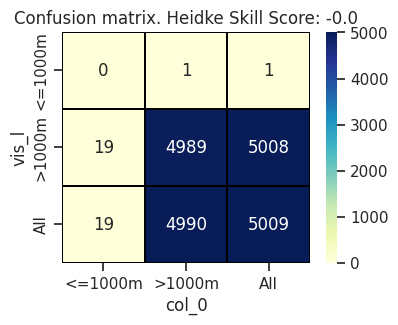

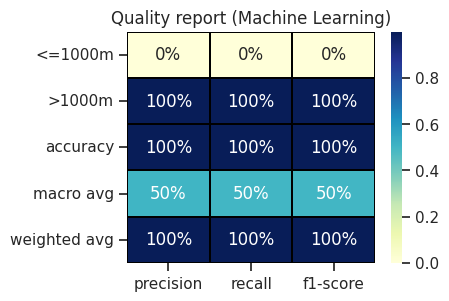

,feature,feature_per
34,lhflx1,7.1%
41,cin1,5.4%
31,temp1,4.6%
3,mod0,4.3%
32,rh1,4.2%
50,hour,3.7%
33,visibility1,3.6%
7,rh0,3.5%
35,lwflx1,3.4%
8,visibility0,3.3%


Round 6


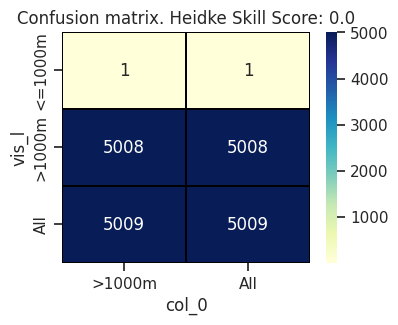

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



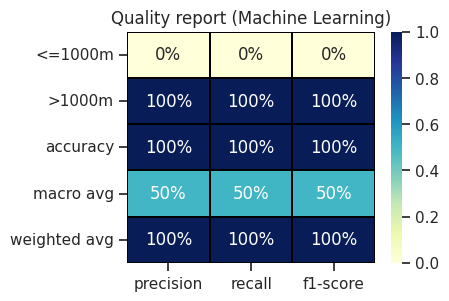

,feature,feature_per
37,prec1,12.2%
7,rh0,9.1%
12,prec0,8.0%
50,hour,7.1%
0,dir0,6.1%
9,lhflx0,5.3%
10,lwflx0,4.1%
34,lhflx1,3.4%
6,temp0,3.3%
31,temp1,3.1%


Round 7


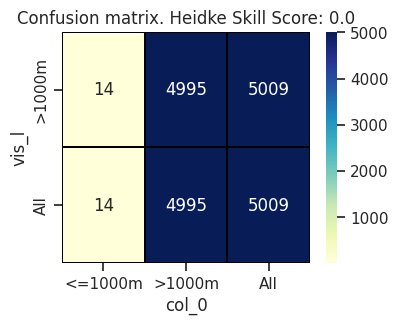

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



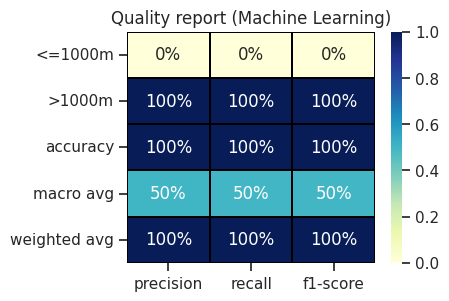

,feature,feature_per
34,lhflx1,6.5%
0,dir0,5.8%
32,rh1,4.6%
3,mod0,4.3%
50,hour,3.6%
41,cin1,3.4%
8,visibility0,3.3%
6,temp0,3.2%
39,shflx1,3.2%
9,lhflx0,2.9%


Round 8


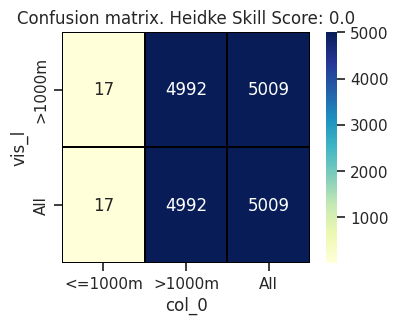

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



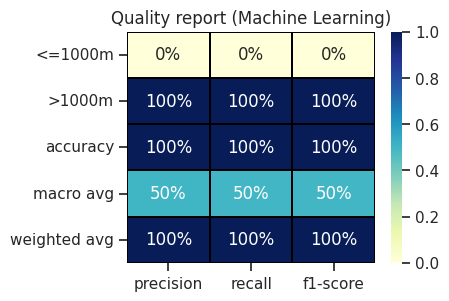

,feature,feature_per
0,dir0,7.9%
2,snowlevel0,6.0%
34,lhflx1,5.6%
7,rh0,5.4%
3,mod0,5.1%
6,temp0,4.6%
32,rh1,3.3%
9,lhflx0,3.3%
4,wind_gust0,3.2%
41,cin1,3.0%


Round 9


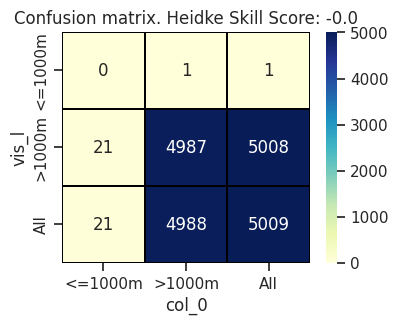

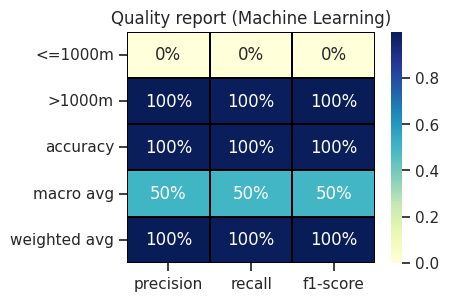

,feature,feature_per
41,cin1,4.7%
0,dir0,4.2%
8,visibility0,4.2%
34,lhflx1,4.0%
32,rh1,3.9%
9,lhflx0,3.8%
31,temp1,3.6%
6,temp0,3.5%
16,cin0,3.5%
35,lwflx1,3.4%



HSS stadistics
             HSS
count  10.000000
mean   -0.000319
std     0.000298
min    -0.001010
25%    -0.000378
50%    -0.000363
75%    -0.000080
max     0.000000
Shapiro test normality
p value: 0.010860986076295376
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 1.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 0.0
Retain H0,There is no association between machine learning forecast and observed values
Execution time: 0.57 minutes


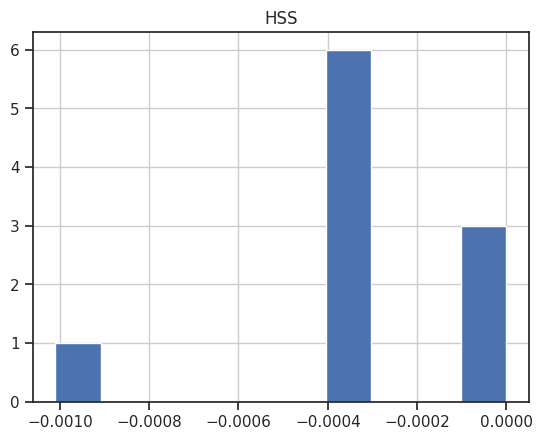

In [9]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score.

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro


start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.vis_l
X = df_all.iloc[:,1:].drop(columns=['vis0_l', 'vis1_l'])


# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  #X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_train,y_train)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")




In [10]:
#@title Save last algorithm round 9


x_var = X.columns
score = {"HSS_ml":HSS[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEBL/algorithms/vis_LEBL_d0.al", 'wb'))

In [14]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.vis_l
X = df_all.iloc[:,1:].drop(columns=['vis0_l', 'vis1_l'])


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  #X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_train,y_test)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")







Round 0


ValueError: ignored

In [ ]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
#pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEBL/algorithms/brfg_LEBL_d0.al", 'wb'))

*****************************


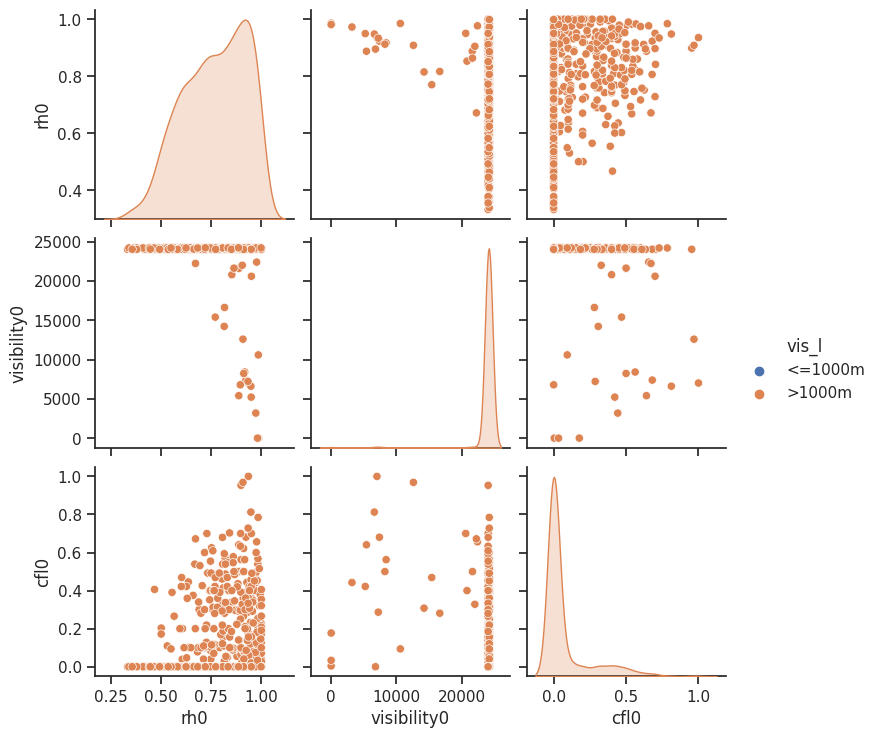

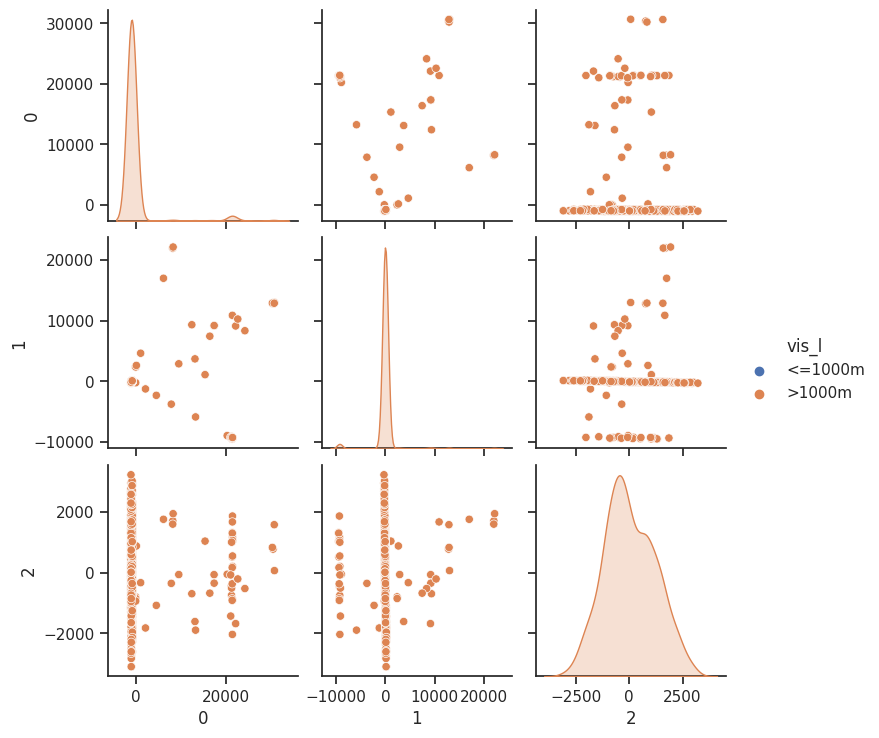

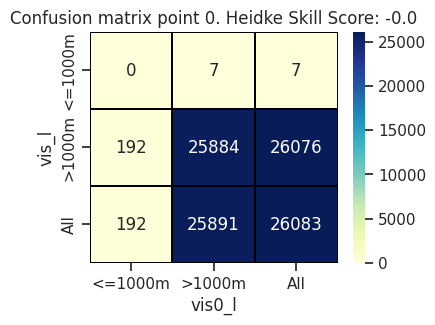

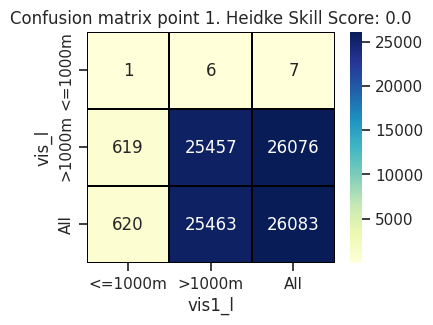

Chi2 contingency test

p-value: 1.0
Significance level: 0.01
Degres of of freedom:  1
Statistic 0.0
Retain H0,There is no association between machine learning forecast and observed values


In [26]:
#@title Load meteorological model forecast D1.Display relation visibility with model variables. Heidke skill score (HSS) meteorological model
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/lat41.296lon2.078p2R12KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/lat41.296lon2.078p2R12KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/lat41.296lon2.078p2R12KmD1Y2020.csv",parse_dates=["time"])

model = pd.concat([mody2018,mody2019,mody2020]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["visibility_o",]).dropna()
#display(df_all)

#display relation br fg with meteorological model variables
print("*****************************")

sns.set_theme(style="ticks")
df = df_all[["vis_l","rh0","visibility0","cfl0"]].sample(1000)
#plt.figure(figsize=(12, 10))
#plt.title("Display relation br fg with meteorological model variables sample=100")
g1 = sns.pairplot(df, hue="vis_l");
plt.show()

#display relation br fg with meteorological PCA
df_pca = pd.DataFrame(PCA(n_components=3).fit_transform(df_all.iloc[:,1:]),
                                                       index =df_all.index)
df_pca["vis_l"] = df_all.vis_l
#plt.figure(figsize=(12, 10))
#plt.title("PCA analysis sample=100")
g2 = sns.pairplot(df_pca.sample(1000), hue="vis_l");
plt.show()

#label meteorological model variables dir0 and dir1
df_all["vis0_l"] = pd.cut(df_all["visibility0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")
df_all["vis1_l"] = pd.cut(df_all["visibility1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_all.vis_l, df_all.vis0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
cm1 = pd.crosstab(df_all.vis_l, df_all.vis1_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()
plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(cm0.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test association between two variables
alpha = 0.01
print("Chi2 contingency test")
print('\np-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Statistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")


In [19]:
X.columns

Index(['dir0', 'snow_prec0', 'snowlevel0', 'mod0', 'wind_gust0', 'mslp0',
       'temp0', 'rh0', 'visibility0', 'lhflx0', 'lwflx0', 'conv_prec0',
       'prec0', 'swflx0', 'shflx0', 'cape0', 'cin0', 'cfh0', 'cfl0', 'cfm0',
       'cft0', 'HGT5000', 'HGT8500', 'T5000', 'T8500', 'dir1', 'snow_prec1',
       'snowlevel1', 'mod1', 'wind_gust1', 'mslp1', 'temp1', 'rh1',
       'visibility1', 'lhflx1', 'lwflx1', 'conv_prec1', 'prec1', 'swflx1',
       'shflx1', 'cape1', 'cin1', 'cfh1', 'cfl1', 'cfm1', 'cft1', 'HGT5001',
       'HGT8501', 'T5001', 'T8501', 'hour', 'month', 'dayofyear',
       'weekofyear'],
      dtype='object')

Round 0


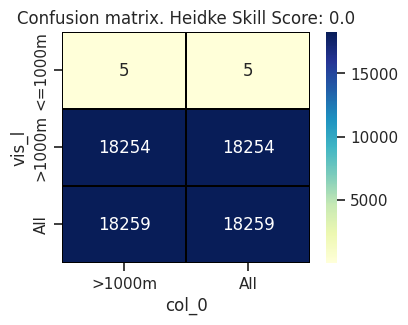

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



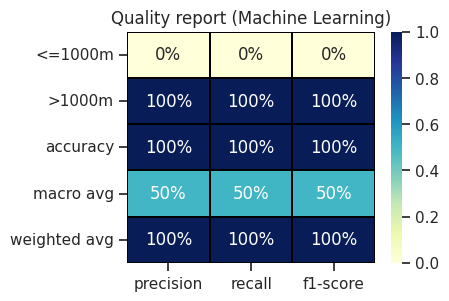

,feature,feature_per
0,dir0,17.9%
7,rh0,12.7%
32,rh1,10.2%
2,snowlevel0,7.5%
31,temp1,6.0%
16,cin0,6.0%
33,visibility1,5.2%
9,lhflx0,5.0%
41,cin1,3.5%
3,mod0,3.0%


Round 1


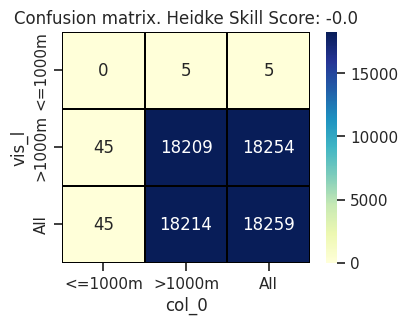

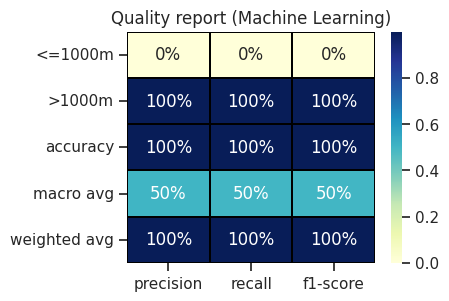

,feature,feature_per
0,dir0,12.3%
2,snowlevel0,7.1%
14,shflx0,6.6%
3,mod0,5.4%
8,visibility0,4.6%
16,cin0,4.5%
40,cape1,4.2%
7,rh0,3.1%
9,lhflx0,2.9%
34,lhflx1,2.8%


Round 2


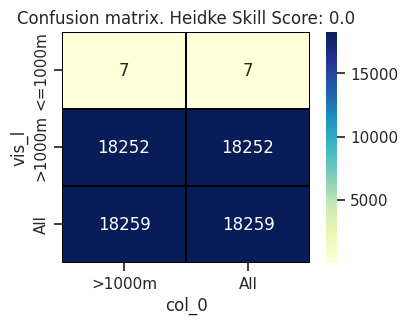

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



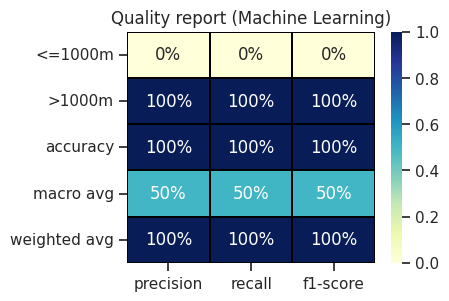

<ipython-input-30-80fde4210786>:53: RuntimeWarning:

invalid value encountered in true_divide



,feature,feature_per
0,dir0,nan%
1,snow_prec0,nan%
2,snowlevel0,nan%
3,mod0,nan%
4,wind_gust0,nan%
5,mslp0,nan%
6,temp0,nan%
7,rh0,nan%
8,visibility0,nan%
9,lhflx0,nan%


Round 3


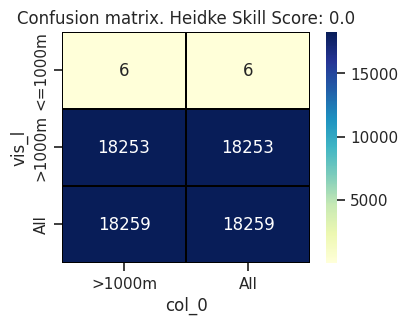

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



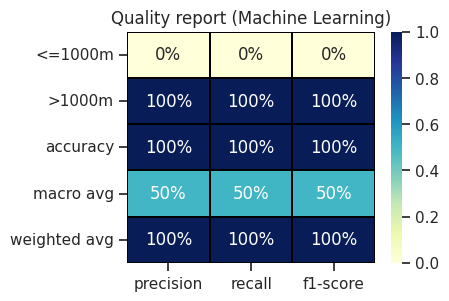

,feature,feature_per
0,dir0,41.8%
50,hour,19.4%
2,snowlevel0,11.2%
7,rh0,6.5%
34,lhflx1,6.5%
3,mod0,2.4%
32,rh1,2.4%
4,wind_gust0,1.8%
15,cape0,1.2%
9,lhflx0,1.2%


Round 4


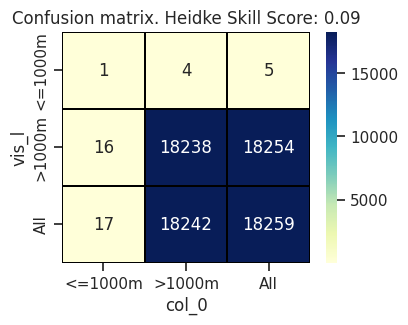

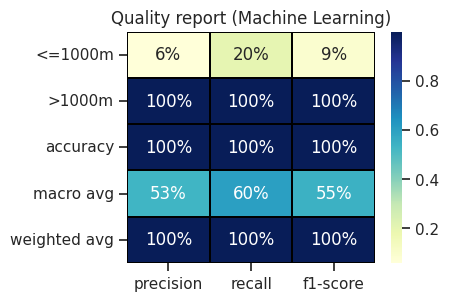

,feature,feature_per
0,dir0,13.4%
7,rh0,7.6%
2,snowlevel0,6.5%
10,lwflx0,6.4%
6,temp0,5.6%
14,shflx0,5.0%
32,rh1,4.3%
5,mslp0,4.1%
9,lhflx0,3.9%
22,HGT8500,3.8%


Round 5


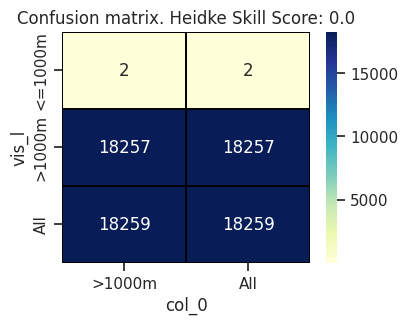

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



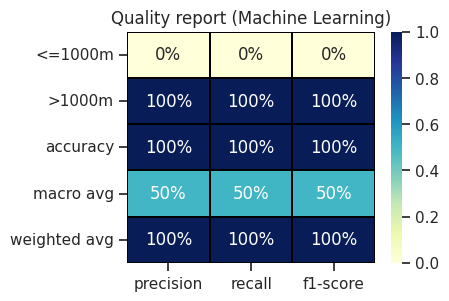

,feature,feature_per
7,rh0,8.7%
32,rh1,6.8%
41,cin1,6.2%
50,hour,5.5%
48,T5001,4.7%
25,dir1,4.4%
14,shflx0,4.2%
21,HGT5000,4.2%
35,lwflx1,4.2%
9,lhflx0,3.7%


Round 6


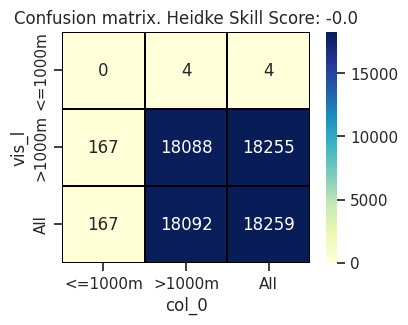

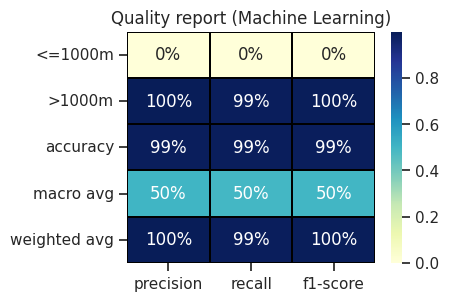

,feature,feature_per
41,cin1,5.8%
7,rh0,5.4%
33,visibility1,4.3%
31,temp1,4.1%
16,cin0,4.0%
6,temp0,4.0%
3,mod0,4.0%
0,dir0,3.8%
9,lhflx0,3.8%
10,lwflx0,3.4%


Round 7


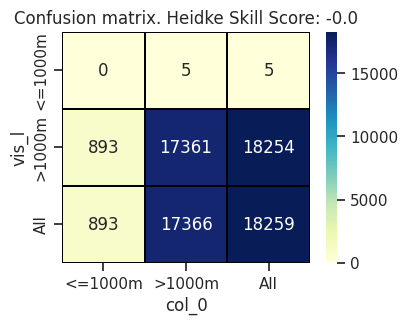

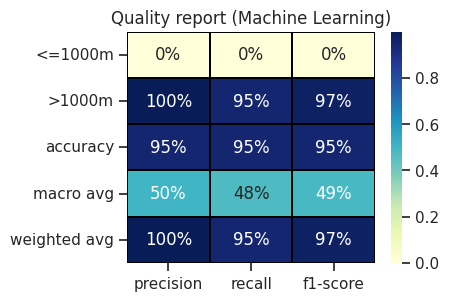

,feature,feature_per
0,dir0,28.0%
35,lwflx1,13.2%
7,rh0,12.4%
2,snowlevel0,11.6%
9,lhflx0,3.2%
3,mod0,3.2%
5,mslp0,2.0%
52,dayofyear,2.0%
10,lwflx0,2.0%
12,prec0,2.0%


Round 8


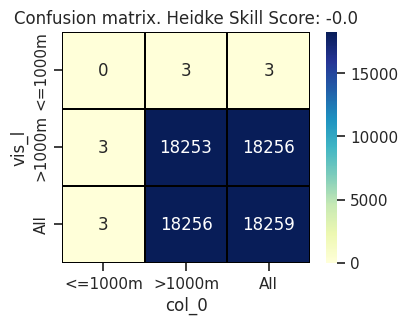

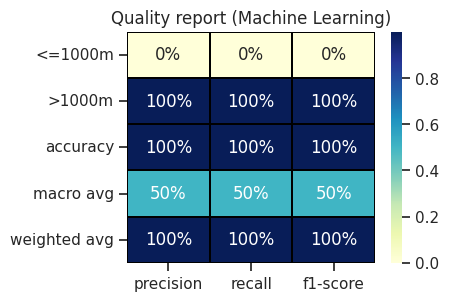

,feature,feature_per
32,rh1,12.1%
7,rh0,8.0%
16,cin0,7.8%
34,lhflx1,6.5%
3,mod0,5.8%
40,cape1,4.8%
41,cin1,4.4%
6,temp0,4.0%
14,shflx0,3.4%
8,visibility0,3.2%


Round 9


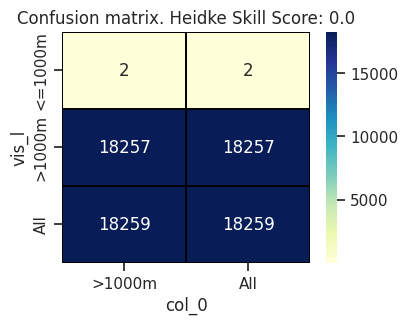

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



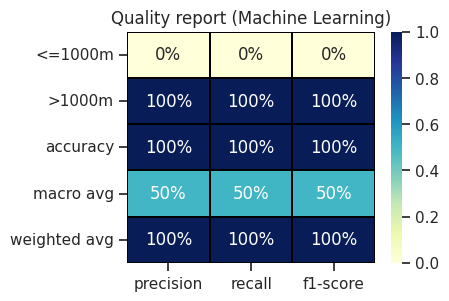

,feature,feature_per
19,cfm0,9.9%
7,rh0,9.2%
50,hour,8.7%
33,visibility1,8.2%
24,T8500,7.7%
34,lhflx1,7.0%
6,temp0,5.1%
31,temp1,4.1%
23,T5000,3.8%
14,shflx0,2.9%



HSS stadistics
             HSS
count  10.000000
mean    0.008889
std     0.028684
min    -0.000545
25%    -0.000362
50%     0.000000
75%     0.000000
max     0.090524
Shapiro test normality
p value: 1.2018118411560863e-07
Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples
chi2_contingency last round
p-value: 1.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 0.0
Retain H0,There is no association between machine learning forecast and observed values
Execution time: 0.49 minutes


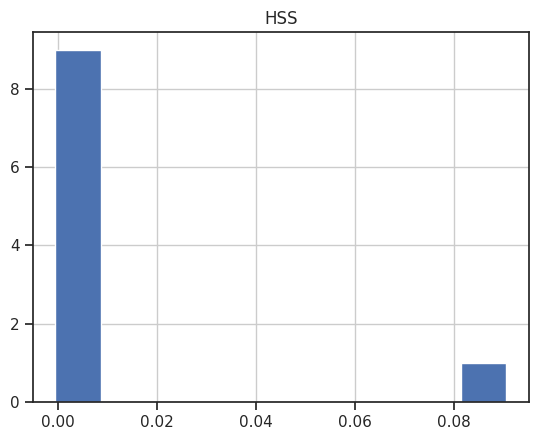

In [30]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score
start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.vis_l
X = df_all.iloc[:,1:].drop(columns=['vis0_l', 'vis1_l'])


# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.7, )

  # Resample
  #X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_train,y_train)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")



In [31]:
#@title Save last algorithm round 9

x_var = X.columns
score = {"HSS_ml":HSS[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEBL/algorithms/vis_LEBL_d1.al", 'wb'))


Round 0


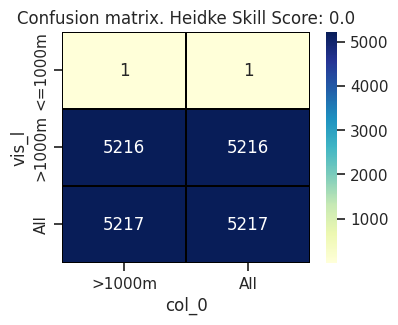

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



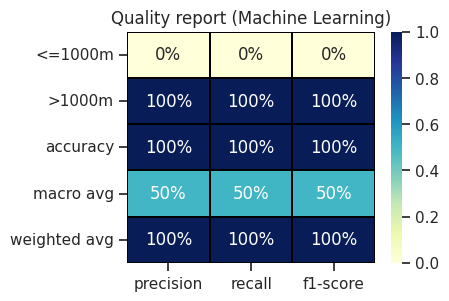

,feature,feature_per
40,cape1,3.8%
3,mod0,3.6%
49,T8501,3.4%
32,rh1,3.3%
31,temp1,3.3%
16,cin0,3.2%
0,dir0,2.9%
6,temp0,2.8%
14,shflx0,2.8%
29,wind_gust1,2.8%


Round 1


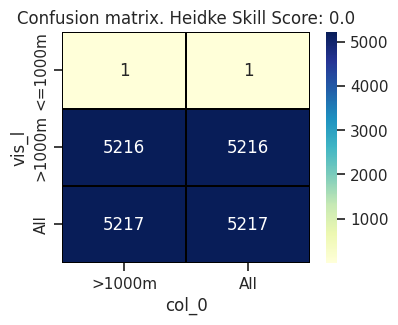

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



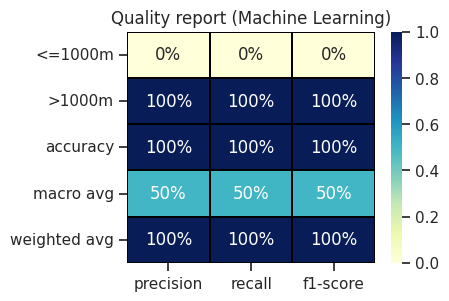

,feature,feature_per
40,cape1,3.6%
49,T8501,3.5%
3,mod0,3.4%
48,T5001,3.3%
4,wind_gust0,3.2%
31,temp1,3.0%
35,lwflx1,3.0%
0,dir0,2.9%
2,snowlevel0,2.7%
16,cin0,2.6%


Round 2


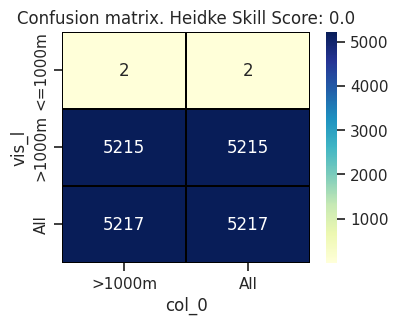

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



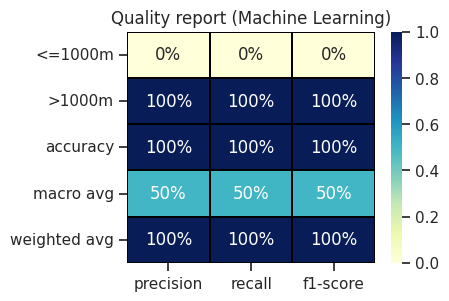

,feature,feature_per
16,cin0,3.8%
25,dir1,3.2%
20,cft0,3.2%
15,cape0,3.1%
6,temp0,3.0%
40,cape1,3.0%
10,lwflx0,2.9%
27,snowlevel1,2.9%
3,mod0,2.9%
49,T8501,2.9%


Round 3


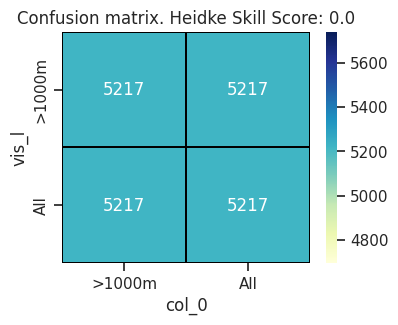

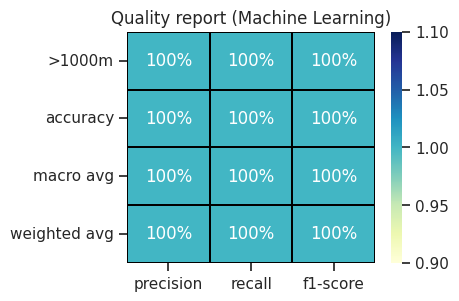

,feature,feature_per
0,dir0,3.4%
16,cin0,3.2%
40,cape1,3.1%
3,mod0,3.0%
46,HGT5001,3.0%
41,cin1,3.0%
4,wind_gust0,2.9%
24,T8500,2.9%
23,T5000,2.9%
6,temp0,2.8%


Round 4


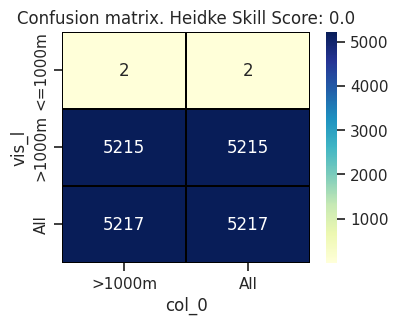

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



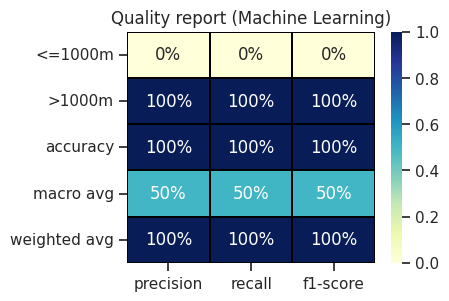

,feature,feature_per
50,hour,4.1%
35,lwflx1,3.5%
49,T8501,3.0%
16,cin0,2.9%
39,shflx1,2.9%
41,cin1,2.9%
25,dir1,2.8%
9,lhflx0,2.8%
32,rh1,2.7%
21,HGT5000,2.5%


Round 5


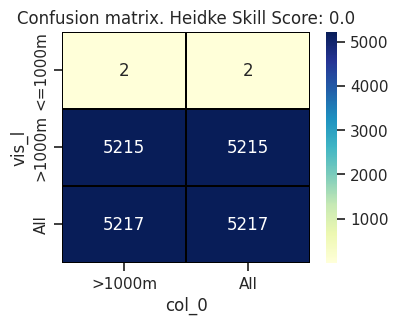

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



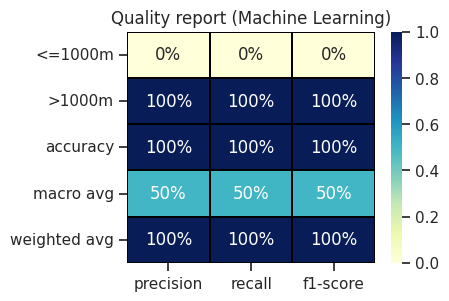

,feature,feature_per
6,temp0,3.6%
3,mod0,3.3%
35,lwflx1,3.2%
48,T5001,3.2%
0,dir0,3.0%
16,cin0,2.9%
40,cape1,2.9%
32,rh1,2.8%
49,T8501,2.8%
10,lwflx0,2.7%


Round 6


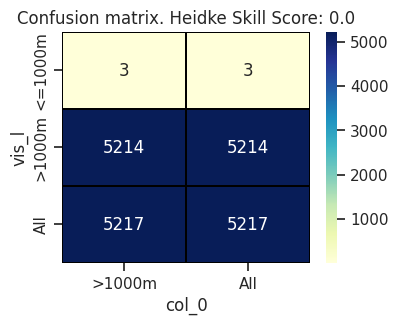

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



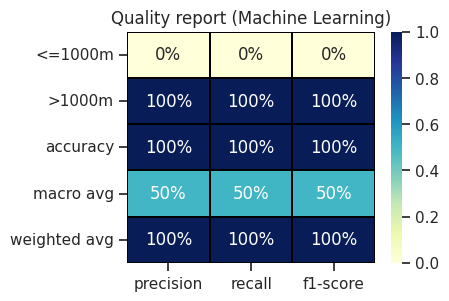

,feature,feature_per
50,hour,4.4%
41,cin1,3.8%
21,HGT5000,3.7%
30,mslp1,3.3%
4,wind_gust0,3.3%
16,cin0,3.0%
39,shflx1,3.0%
34,lhflx1,2.9%
6,temp0,2.8%
48,T5001,2.7%


Round 7


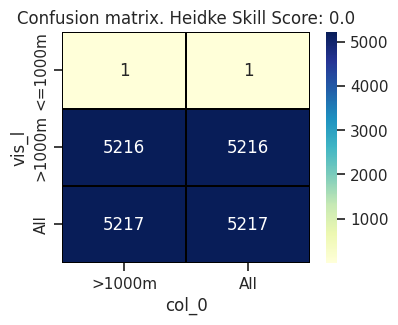

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



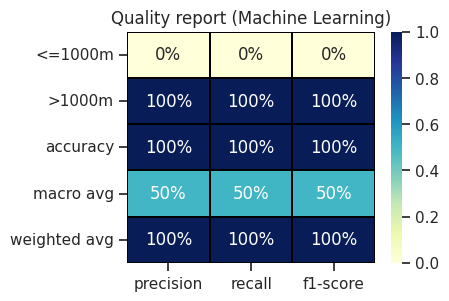

,feature,feature_per
50,hour,3.8%
3,mod0,3.2%
6,temp0,3.0%
29,wind_gust1,2.9%
28,mod1,2.9%
7,rh0,2.8%
35,lwflx1,2.8%
25,dir1,2.8%
40,cape1,2.8%
27,snowlevel1,2.7%


Round 8


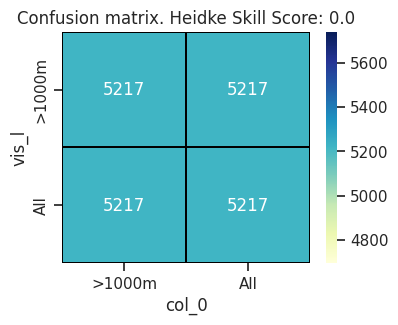

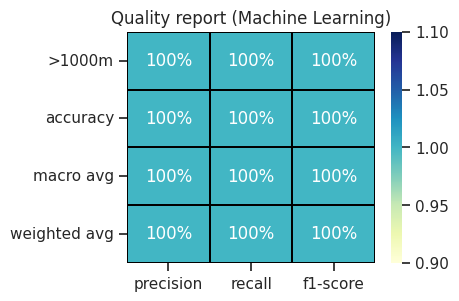

,feature,feature_per
40,cape1,3.9%
30,mslp1,3.4%
50,hour,3.3%
16,cin0,3.3%
4,wind_gust0,2.8%
3,mod0,2.8%
41,cin1,2.8%
0,dir0,2.7%
24,T8500,2.6%
7,rh0,2.5%


Round 9


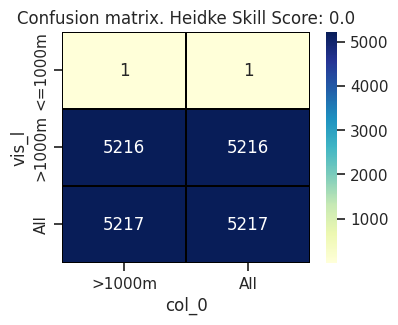

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



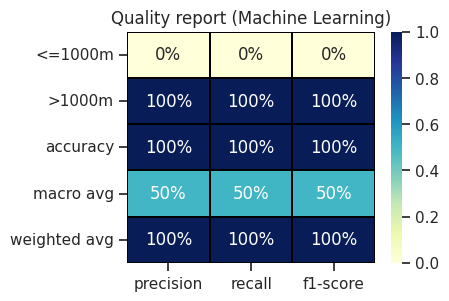

,feature,feature_per
41,cin1,3.7%
32,rh1,3.4%
40,cape1,3.1%
0,dir0,3.1%
28,mod1,3.0%
24,T8500,3.0%
27,snowlevel1,2.9%
4,wind_gust0,2.9%
50,hour,2.9%
7,rh0,2.8%



HSS stadistics
        HSS
count  10.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0
Shapiro test normality
p value: 1.0
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 1.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 0.0
Retain H0,There is no association between machine learning forecast and observed values
Execution time: 0.38 minutes


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1813: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.



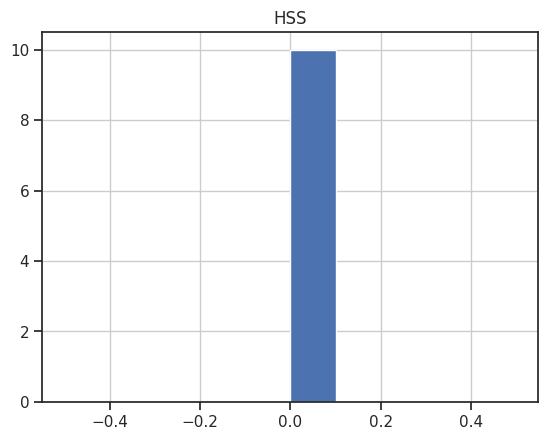

In [33]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.vis_l
X = df_all.iloc[:,1:].drop(columns=['vis0_l', 'vis1_l'])


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  #X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_train,y_train)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")



In [34]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
#pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEBL/algorithms/vis_LEBL_d1.al", 'wb'))